In [1830]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV


In [1831]:
df_ames = pd.read_csv('datasets/Ames_Post_EDA.csv', na_filter=False)

In [1832]:
df_ames_test = pd.read_csv('datasets/Ames_Test_Post_EDA.csv', na_filter=False)

In [1833]:
df_ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033 entries, 0 to 2032
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2033 non-null   int64  
 1   id               2033 non-null   int64  
 2   pid              2033 non-null   int64  
 3   ms_subclass      2033 non-null   int64  
 4   ms_zoning        2033 non-null   object 
 5   lot_frontage     2033 non-null   float64
 6   lot_area         2033 non-null   int64  
 7   street           2033 non-null   object 
 8   alley            2033 non-null   object 
 9   lot_shape        2033 non-null   object 
 10  land_contour     2033 non-null   object 
 11  utilities        2033 non-null   object 
 12  lot_config       2033 non-null   object 
 13  land_slope       2033 non-null   object 
 14  neighborhood     2033 non-null   object 
 15  condition_1      2033 non-null   object 
 16  condition_2      2033 non-null   object 
 17  bldg_type     

In [1834]:
df_ames_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       878 non-null    int64  
 1   id               878 non-null    int64  
 2   pid              878 non-null    int64  
 3   ms_subclass      878 non-null    int64  
 4   ms_zoning        878 non-null    object 
 5   lot_frontage     878 non-null    float64
 6   lot_area         878 non-null    int64  
 7   street           878 non-null    object 
 8   alley            878 non-null    object 
 9   lot_shape        878 non-null    object 
 10  land_contour     878 non-null    object 
 11  utilities        878 non-null    object 
 12  lot_config       878 non-null    object 
 13  land_slope       878 non-null    object 
 14  neighborhood     878 non-null    object 
 15  condition_1      878 non-null    object 
 16  condition_2      878 non-null    object 
 17  bldg_type       

In [1835]:
df_ames.drop(columns='Unnamed: 0', inplace=True)
df_ames_test.drop(columns='Unnamed: 0', inplace=True)

In [1836]:
# Update the correct data types for the columns
df_ames['id'] = df_ames['id'].astype(object)
df_ames['pid'] = df_ames['pid'].astype(object)
df_ames['ms_subclass'] = df_ames['ms_subclass'].astype(object)

df_ames_test['id'] = df_ames_test['id'].astype(object)
df_ames_test['pid'] = df_ames_test['pid'].astype(object)
df_ames_test['ms_subclass'] = df_ames_test['ms_subclass'].astype(object)


In [1837]:
# We map the ordinal columns to numerical values to enable the model to interpret them as numbers

dict_ordinals = dict(lot_shape={'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
                          utilities = {'AllPub':2, 'NoSewr':1, 'NoSeWa':0},
                          land_slope = {'Gtl':2, 'Mod':1, 'Sev':0},
                          exter_qual = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
                          exter_cond = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
                          bsmt_qual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                          bsmt_cond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                          bsmt_exposure = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0},
                          bsmtfin_type_1 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
                          bsmtFin_type_2 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0},
                          heating_qc = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
                          kitchen_qual = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
                          electrical = {'SBrkr':4, 'FuseA':3, 'FuseF':2, 'FuseP':1, 'Mix':0},
                          garage_qual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                          garage_cond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                          fireplace_qu = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0},
                          functional = {'Typ':7, 'Min1':6,'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0},
                          garage_finish = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0},
                          paved_drive = {'Y':2, 'P':1, 'N':0},
                          pool_qc = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0},
                          fence = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0})


df_ames = df_ames.replace(dict_ordinals)
df_ames_test = df_ames_test.replace(dict_ordinals)


In [1838]:
# As mentioned earlier, we take a log of the saleprice to make the distribution normal
#df_ames['saleprice'] = np.log(df_ames['saleprice'])

In [1839]:
# We do one-hot encoding on the categorical variables. i.e. all variables which are Nominal and Ordinal
df_ames_test.select_dtypes(include='object').columns


Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'street', 'alley',
       'land_contour', 'lot_config', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation',
       'bsmtfin_type_2', 'heating', 'central_air', 'garage_type',
       'misc_feature', 'sale_type'],
      dtype='object')

In [1840]:
df_ames_test.select_dtypes(include='object').columns


Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'street', 'alley',
       'land_contour', 'lot_config', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation',
       'bsmtfin_type_2', 'heating', 'central_air', 'garage_type',
       'misc_feature', 'sale_type'],
      dtype='object')

In [1841]:
# We first combine the train and test dataset. This is 
# because we want to have the same structure of columns when we do one-hot encoding on the data
pd.concat([df_ames, df_ames_test]).shape


(2911, 81)

In [1842]:
df_ames_dummy = pd.get_dummies(pd.concat([df_ames, df_ames_test]), 
        columns=['ms_subclass', 'ms_zoning', 'street', 'alley',
       'land_contour', 'lot_config', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation',
       'bsmtfin_type_2', 'heating', 'central_air', 'garage_type',
       'misc_feature', 'sale_type'], drop_first=True)

In [1843]:
df_ames_dummy.head()

,id,pid,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,...,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,109,533352170,68.0,13517,2,2,2,6,8,1976,...,0,0,0,0,0,0,0,0,0,1
1,544,531379050,43.0,11492,2,2,2,7,5,1996,...,0,0,0,0,0,0,0,0,0,1
2,153,535304180,68.0,7922,3,2,2,5,7,1953,...,0,0,0,0,0,0,0,0,0,1
3,318,916386060,73.0,9802,3,2,2,5,5,2006,...,0,0,0,0,0,0,0,0,0,1
4,255,906425045,82.0,14235,2,2,2,6,8,1900,...,0,0,0,0,0,0,0,0,0,1


In [1844]:
# Separate the test data
df_ames_dummy_test = df_ames_dummy[df_ames_dummy['saleprice'].isnull()]

In [1845]:
# Drop the Sale Price column to return the test dataset back to it's oroginal structure
df_ames_dummy_test = df_ames_dummy_test.drop(columns='saleprice')

In [1846]:
# Separate the training data back
df_ames_dummy = df_ames_dummy[df_ames_dummy['saleprice'].notnull()]

In [1847]:
df_ames_dummy.shape

(2033, 224)

In [1848]:
# Define X and y 

X = df_ames_dummy.drop(columns='saleprice')
y = df_ames_dummy['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [1849]:
X_train.shape

(1524, 223)

### Standardising the data

In [1850]:
# We standardise the train data

#First drop id and pid columns as otherwise Standard Scaler will automatically standardize them
ss = StandardScaler()

X_train_no_ids = X_train.drop(columns=['id','pid'])
X_test_no_ids = X_test.drop(columns=['id','pid'])

ss.fit(X_train_no_ids)

X_train_sc = ss.transform(X_train_no_ids)
X_test_sc = ss.transform(X_test_no_ids)

X_train_sc = pd.DataFrame(X_train_sc, index=X_train_no_ids.index , columns=X_train_no_ids.columns)
X_test_sc = pd.DataFrame(X_test_sc, index=X_test_no_ids.index, columns=X_test_no_ids.columns)


In [1851]:
y_train

702     215000.0
136      94000.0
482     107500.0
233     190000.0
556     155900.0
          ...   
2012    102776.0
1346    318000.0
1406    198000.0
1389    125000.0
1534    163000.0
Name: saleprice, Length: 1524, dtype: float64

### Linear Regression

In [1923]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression()

In [1924]:
train_score = lr.score(X_train_sc, y_train)
print(f"Training r2 score {round(train_score, 3)}")

test_score = lr.score(X_test_sc, y_test)
print(f"Testing r2 score {round(test_score, 3)}")
    

Training r2 score 0.936
Testing r2 score -9.978045291868154e+23


In [1925]:
# Check the MSE on the training and testing sets.

print(f'MSE on training set: {round(mean_squared_error(y_train, lr.predict(X_train_sc)), 3)}')
print(f'MSE on testing set: {round(mean_squared_error(y_test, lr.predict(X_test_sc)))}')


MSE on training set: 409239143.703
MSE on testing set: 5970701065163056515930236194390016


In [1926]:
# Check the RMSE on the training and testing sets.

print(f'RMSE on training set: {round(mean_squared_error(y_train, lr.predict(X_train_sc), squared=False),3)}')
print(f'RMSE on testing set: {round(mean_squared_error(y_test, lr.predict(X_test_sc), squared=False),3)}')



RMSE on training set: 20229.66
RMSE on testing set: 7.727031166730891e+16


### Cross Validation

In [1927]:
cross_val_scores = cross_val_score(lr, X_train_sc, y_train)

print(f'Cross Val Scores : {cross_val_scores}')
print(f'Cross Val Score Mean : {round(np.mean(cross_val_scores), 3)}')


Cross Val Scores : [-4.32385637e+20 -1.14713888e+24 -8.00059991e+20 -4.99183154e+22
 -4.08579952e+21]
Cross Val Score Mean : -2.4047508728370497e+23


**Interpretation:** 
1. The testing r2 score is much worse than the training score, indicating an overfit. A negative testing score shows a poor fit. 
2. The MSE and RMSE  values are very high, indicating a bad model. The MSE value of the testing set is much worse than the training set indicating overfitting
3. A negative mean cross val score also shows that the model is very poorly fit, possibly because of non-related variables being a part of the model.

 

In [1950]:
#Find the baseline score of the model
y_baseline = y_test.to_frame()
y_baseline['mean_y'] = y_train.mean()

In [1951]:
lr.score(X_test_sc, y_baseline['mean_y'])

0.0

In [ ]:
r2_score(y_train, y_baseline)

Since the r2 value for the baseline model is 0, it appears that our liner regression model (with negative r2 score is performing worse than the baseline model.

Hence we use regularisation, to do feature selection and reduce the overfitting of the model.

###  Lasso Regularisation

In [1857]:
# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(n_alphas=500, cv=5, max_iter=50000)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train);

print (f"Optimal value of alpha: {lasso_cv.alpha_}")

print(f"Train r2 score: {round(lasso_cv.score(X_train_sc, y_train), 3)}")
print(f"Test r2 score: {round(lasso_cv.score(X_test_sc, y_test),3)}")

lasso_train_pred = lasso_cv.predict(X_train_sc)
lasso_test_pred = lasso_cv.predict(X_test_sc)

Optimal value of alpha: 368.37297513518166
Train r2 score: 0.93
Test r2 score: 0.91


In [1858]:
# Check the MSE on the training and testing sets.

print(f'MSE on training set: {round(mean_squared_error(y_train, lasso_train_pred), 3)}')
print(f'MSE on testing set: {round(mean_squared_error(y_test, lasso_test_pred), 3)}')


MSE on training set: 447259323.765
MSE on testing set: 535844659.49


In [1859]:
# Check the RMSE on the training and testing sets.

print(f'RMSE on training set: {round(mean_squared_error(y_train, lasso_train_pred, squared=False), 3)}')
print(f'RMSE on testing set: {round(mean_squared_error(y_test, lasso_test_pred, squared=False), 3)}')


RMSE on training set: 21148.506
RMSE on testing set: 23148.319


**Cross-validate the Lasso $R^2$ with the optimal alpha.**

In [1860]:
lasso = Lasso(alpha=lasso_cv.alpha_)

lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=10)

print(f" Lasso scores with optimal alpha, with cross validation: \n{lasso_scores}\n")
print(f" Lasso mean score with optimal alpha, with cross validation: {round(np.mean(lasso_scores),3)}")


 Lasso scores with optimal alpha, with cross validation: 
[0.90650263 0.88908718 0.92239408 0.90864232 0.91885719 0.92477601
 0.86416264 0.90528931 0.90763827 0.92068203]

 Lasso mean score with optimal alpha, with cross validation: 0.907


**Interpretation:**  Lasso helps with the feature selection of relevant variables, and eliminating the redundant variables and also manages multicollinearity. It keeps the best variables and reduces the redundant variables to zero. 

1. The train and test r2 scores  are much better than for linear regression. However r2 score for testing is still a bit worse than train score indicating possibility of overfitting.
2. The MSE values much lower than the linear model, and the RMSE scores show that the predictions on the test model miss the actual sale price by 21,873\\$
3. Cross val score is much closer to the train and test scores, indicating that the model generalises well on test data. However the cross val score are still slightly worse than the train score, indicating possible overfitting.

In [1861]:
df_lasso_cv = pd.DataFrame(lasso_cv.coef_, columns=['coefficient'])
df_lasso_cv['col_name'] = X_train_sc.columns
df_lasso_cv['abs_coef'] = abs(df_lasso_cv['coefficient'])

In [1862]:
df_lasso_cv[df_lasso_cv['abs_coef'] != 0].sort_values(by='abs_coef' ,ascending=False)[0:50]


,coefficient,col_name,abs_coef
25,24238.070474,gr_liv_area,24238.070474
5,12626.762870,overall_qual,12626.762870
16,10235.307441,bsmtfin_sf_1,10235.307441
7,6998.809370,year_built,6998.809370
104,6772.647610,neighborhood_NridgHt,6772.647610
110,6518.949748,neighborhood_StoneBr,6518.949748
19,6008.617164,total_bsmt_sf,6008.617164
10,5768.198351,exter_qual,5768.198351
9,5300.631487,mas_vnr_area,5300.631487
6,5235.981089,overall_cond,5235.981089


In [1863]:
# Find all columns that have zero coefficients so we can drop them for the future models
drop_columns = []
drop_columns = df_lasso_cv[df_lasso_cv['abs_coef'] == 0]['col_name'].tolist()
len(drop_columns)


98

In [1864]:
# We drop the variables with zero coefficients and try the Ridge Regression again

X_train_regularised = X_train_sc.drop(columns=drop_columns)
X_train_regularised

,lot_frontage,lot_area,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,...,garage_type_BuiltIn,garage_type_NA,misc_feature_Othr,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLw,sale_type_New,sale_type_Oth
702,0.558342,-0.065878,0.208033,1.321151,-0.497230,0.698027,0.464314,0.144259,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
136,-0.726578,-0.681520,0.208033,-0.763149,2.218821,-3.200344,0.558732,-0.578783,-0.688340,2.458787,...,-0.259281,4.114537,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
482,-0.430058,-0.517068,0.208033,-0.763149,1.313471,-0.557381,1.078030,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
233,-0.479478,-0.059553,0.208033,0.626384,-0.497230,1.094471,0.983612,0.473966,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
556,-1.566718,-1.047034,0.208033,-0.068383,-0.497230,1.061434,0.936404,0.398770,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,-0.133538,-0.227263,-4.195340,-1.457916,1.313471,-2.374418,-1.612879,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
1346,1.200802,0.419238,0.208033,1.321151,-0.497230,1.160545,1.078030,1.318479,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,3.330952,-0.051299
1406,-0.034698,2.069129,0.208033,0.626384,-0.497230,-0.028788,-0.621491,3.192603,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
1389,-0.430058,1.171924,0.208033,-1.457916,-1.402580,-0.590418,-0.763118,-0.231723,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299


**Drop variables with zero coefficients for future models**

In [1865]:
# We drop the variables with zero coefficients and try the Ridge Regression again

X_test_regularised = X_test_sc.drop(columns=drop_columns)
X_test_regularised

,lot_frontage,lot_area,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,...,garage_type_BuiltIn,garage_type_NA,misc_feature_Othr,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLw,sale_type_New,sale_type_Oth
1185,0.706602,0.047016,0.208033,-0.068383,1.313471,-0.293084,-0.999163,1.127596,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
822,-0.430058,0.098191,0.208033,-1.457916,-0.497230,-1.878862,-1.612879,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
865,-2.209178,-1.413698,0.208033,0.626384,-0.497230,1.061434,0.936404,-0.289566,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
543,0.311242,0.029190,0.208033,-0.763149,-0.497230,-0.557381,-1.376834,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
427,-1.369038,-0.863031,0.208033,1.321151,-0.497230,0.698027,0.417105,-0.578783,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.558342,0.786285,0.208033,-0.068383,2.218821,-0.722566,0.936404,-0.578783,-0.688340,2.458787,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
828,-0.825418,-0.800739,0.208033,-0.763149,0.408121,-1.019899,-1.612879,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
1309,0.014722,-0.059361,0.208033,1.321151,-0.497230,1.160545,1.078030,0.982988,1.011872,-0.229299,...,3.856812,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,3.330952,-0.051299
1658,0.360662,-0.058786,0.208033,1.321151,-0.497230,1.061434,0.983612,1.411028,1.011872,-0.229299,...,3.856812,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299


###  Ridge Regularisation

**Ridge Regression on variables with non-zero coeffiecients**

In [1866]:
# We use Ridge Regression to reduce the weightage of any redundant variable and to manage multi-colinearity

# Set up a list of ridge alphas to check.
r_alphas = np.logspace(-1, 5, 200)

# Cross-validate over our list of ridge alphas.
ridge_cv2 = RidgeCV(alphas=r_alphas, cv=10)

# Fit model using best ridge alpha!
ridge_cv2.fit(X_train_regularised, y_train)

print (f"Optimal value of alpha: {ridge_cv2.alpha_}")

print(f"Train r2 score: {round(ridge_cv2.score(X_train_regularised, y_train),3)}")
print(f"Test r2 score: {round(ridge_cv2.score(X_test_regularised, y_test), 3)}")

ridge_train_pred = ridge_cv2.predict(X_train_regularised)
ridge_test_pred = ridge_cv2.predict(X_test_regularised)


Optimal value of alpha: 68.26071834272386
Train r2 score: 0.932
Test r2 score: 0.905


In [1867]:
# Check the MSE on the training and testing sets.

print(f'MSE on training set: {round(mean_squared_error(y_train, ridge_train_pred),3)}')
print(f'MSE on testing set: {round(mean_squared_error(y_test, ridge_test_pred),3)}')


MSE on training set: 433920953.716
MSE on testing set: 571192062.093


In [1868]:
# Check the RMSE on the training and testing sets.

print(f'RMSE on training set: {round(mean_squared_error(y_train, ridge_train_pred, squared=False),3)}')
print(f'RMSE on testing set: {round(mean_squared_error(y_test, ridge_test_pred, squared=False),3)}')


RMSE on training set: 20830.769
RMSE on testing set: 23899.625


**Cross-validate the Ridge regression $R^2$ with the optimal alpha.**

In [1869]:
ridge2 = Ridge(alpha=ridge_cv2.alpha_)

ridge_scores2 = cross_val_score(ridge2, X_train_regularised, y_train, cv=10)

print(f" Ridge scores with optimal alpha, with cross validation: \n{ridge_scores2}\n")
print(f" Ridge mean scores with optimal alpha, with cross validation: {round(np.mean(ridge_scores2),3)}")


 Ridge scores with optimal alpha, with cross validation: 
[0.91410286 0.89080968 0.92615581 0.90858946 0.92331324 0.93049477
 0.87228097 0.91686541 0.91046814 0.91948471]

 Ridge mean scores with optimal alpha, with cross validation: 0.911


**Interpretation** 

1. The train and test r2 scores are fairly ghood, slightly better than Lasso. However r2 score for testing is still a bit worse than train score indicating possibility of overfitting.
2. The train MSE value is lower than the Lasso but test MSE is slightly higher than Lasso, and the RMSE scores show that the predictions on the test model miss the actual Sale Price by 22,008\\$
3. Cross val score is  closer to the train and test scores compared to Lasso, indicating that the model generalises well on test data.

### Feature Engineering

We try to engineer features using PolynomialFeatures transform

**Polynomial Faetures**

In [1870]:
poly = PolynomialFeatures(include_bias=False, degree=2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train_regularised))
X_test_poly = pd.DataFrame(poly.transform(X_test_regularised))


In [1871]:
X_train_poly

,0,1,2,3,4,5,6,7,8,9,...,7739,7740,7741,7742,7743,7744,7745,7746,7747,7748
0,0.558342,-0.065878,0.208033,1.321151,-0.497230,0.698027,0.464314,0.144259,1.011872,-0.229299,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632
1,-0.726578,-0.681520,0.208033,-0.763149,2.218821,-3.200344,0.558732,-0.578783,-0.688340,2.458787,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632
2,-0.430058,-0.517068,0.208033,-0.763149,1.313471,-0.557381,1.078030,-0.578783,-0.688340,-0.229299,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632
3,-0.479478,-0.059553,0.208033,0.626384,-0.497230,1.094471,0.983612,0.473966,1.011872,-0.229299,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632
4,-1.566718,-1.047034,0.208033,-0.068383,-0.497230,1.061434,0.936404,0.398770,1.011872,-0.229299,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,-0.133538,-0.227263,-4.195340,-1.457916,1.313471,-2.374418,-1.612879,-0.578783,-0.688340,-0.229299,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632
1520,1.200802,0.419238,0.208033,1.321151,-0.497230,1.160545,1.078030,1.318479,1.011872,-0.229299,...,0.007937,0.00457,-0.296745,0.00457,0.002632,-0.170874,0.002632,11.095238,-0.170874,0.002632
1521,-0.034698,2.069129,0.208033,0.626384,-0.497230,-0.028788,-0.621491,3.192603,-0.688340,-0.229299,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632
1522,-0.430058,1.171924,0.208033,-1.457916,-1.402580,-0.590418,-0.763118,-0.231723,-0.688340,-0.229299,...,0.007937,0.00457,0.026745,0.00457,0.002632,0.015401,0.002632,0.090129,0.015401,0.002632


**Feature Engineering - Adding Interaction Terms**

We try to engineer features which may work better together than independently. 

In [1872]:
# Make a copy ofthe train and test dataset for feature engineering (FE)

X_train_sc_FE = X_train_regularised.copy()
X_test_sc_FE = X_test_regularised.copy()

# Home buyers may prefer big houses with over all good quality
try:
    X_train_sc_FE['gr_liv_area*overall_qual'] = X_train_sc_FE['gr_liv_area'] * X_train_sc_FE['overall_qual']
    X_test_sc_FE['gr_liv_area*overall_qual'] = X_test_sc_FE['gr_liv_area'] * X_test_sc_FE['overall_qual']
except:
    print("One of the variables was dropped due to being seroed out with Lasso")    

In [1873]:
# Home buyers may prefer houses with good over all condition which have been recently remodeled. 

try:
    X_train_sc_FE['overall_cond*year_remod/add'] = X_train_sc_FE['overall_cond'] * X_train_sc_FE['year_remod/add']
    X_test_sc_FE['overall_cond*year_remod/add'] = X_test_sc_FE['overall_cond'] * X_test_sc_FE['year_remod/add']
except:
    print("One of the variables was dropped due to being seroed out with Lasso")

In [1874]:
# Home buyers may houses with big garages which can accommodate more number of cars

try:
    X_train_sc_FE['garage_cars*garage_area'] = X_train_sc_FE['garage_cars'] * X_train_sc_FE['garage_area']
    X_test_sc_FE['garage_cars*garage_area'] = X_test_sc_FE['garage_cars'] * X_test_sc_FE['garage_area']
except:
    print("One of the variables was dropped due to being seroed out with Lasso")

In [1875]:
# Home buyers may houses big lots which have a high frontage (Linear feet of street connected to property). 

try:
    X_train_sc_FE['lot_frontage*lot_area'] = X_train_sc_FE['lot_frontage'] * X_train_sc_FE['lot_area']
    X_test_sc_FE['lot_frontage*lot_area'] = X_test_sc_FE['lot_frontage'] * X_test_sc_FE['lot_area']
except:
    print("One of the variables was dropped due to being seroed out with Lasso")    

In [1876]:
# Home buyers may houses with good quality basements which have a high amount of exposure

try:
    X_train_sc_FE['bsmt_qual*bsmt_exposure'] = X_train_sc_FE['bsmt_qual'] * X_train_sc_FE['bsmt_exposure']
    X_test_sc_FE['bsmt_qual*bsmt_exposure'] = X_test_sc_FE['bsmt_qual'] * X_test_sc_FE['bsmt_exposure']
except:
    print("One of the variables was dropped due to being seroed out with Lasso")    

In [1877]:
# Home buyers may houses with over all good quality which have high functionality

try:
    X_train_sc_FE['overall_qual*functional'] = X_train_sc_FE['overall_qual'] * X_train_sc_FE['functional']
    X_test_sc_FE['overall_qual*functional'] = X_test_sc_FE['overall_qual'] * X_test_sc_FE['functional']
except:
    print("One of the variables was dropped due to being seroed out with Lasso")    

**Perform Lasso Regression with the new feature**

In [1878]:
# Cross-validate our new features over our list of Lasso alphas.
lasso_cv4 = LassoCV(n_alphas=500, cv=5, max_iter=50000)

# Fit model using best lasso
lasso_cv4.fit(X_train_sc_FE, y_train);

print (f"Optimal value of alpha: {lasso_cv4.alpha_}")

print(f"Train r2 score: {round(lasso_cv4.score(X_train_sc_FE, y_train),3)}")
print(f"Test r2 score: {round(lasso_cv4.score(X_test_sc_FE, y_test),3)}")

lasso4_train_pred = lasso_cv4.predict(X_train_sc_FE)
lasso4_test_pred = lasso_cv4.predict(X_test_sc_FE)

Optimal value of alpha: 233.28723087342348
Train r2 score: 0.943
Test r2 score: 0.93


In [1879]:
# Check the MSE on the training and testing sets.

print(f'MSE on training set: {round(mean_squared_error(y_train, lasso4_train_pred),3)}')
print(f'MSE on testing set: {round(mean_squared_error(y_test, lasso4_test_pred),3)}')


MSE on training set: 361755706.525
MSE on testing set: 418124303.75


In [1880]:
# Check the RMSE on the training and testing sets.

print(f'RMSE on training set: {round(mean_squared_error(y_train, lasso4_train_pred, squared=False),3)}')
print(f'RMSE on testing set: {round(mean_squared_error(y_test, lasso4_test_pred, squared=False),3)}')


RMSE on training set: 19019.877
RMSE on testing set: 20448.088


**Cross-validate the Lasso $R^2$ with the optimal alpha.**

In [1881]:
lasso4 = Lasso(alpha=lasso_cv4.alpha_)

lasso_scores4 = cross_val_score(lasso4, X_train_sc_FE, y_train, cv=10)

print(f" Lasso Scores with optimal alpha, with cross validation: \n{lasso_scores4}\n")
print(f" Lasso Mean Score with optimal alpha, with cross validation: {round(np.mean(lasso_scores4),3)}")

 Lasso Scores with optimal alpha, with cross validation: 
[0.93244529 0.91542384 0.93189269 0.94001287 0.94157057 0.93012885
 0.86901048 0.92067306 0.92424051 0.93481229]

 Lasso Mean Score with optimal alpha, with cross validation: 0.924


**Interpretation:** 

1. The train r2 is better than previous Lasso and Ridge models . Test r2 score is also better than previous models. The 0.02 difference in train and test scores still persists. 
2. The train MSE value  than the previous Lasso and Ridge models. Test MSE is also lower however difference between train and test score still presists. RMSE scores show that the predictions on the test model miss the actual Sale Price by 20,276$
3. Cross val score is  slightly closer to the train and test scores compared previous models, indicating that the model generalises better on test data.

The Lasso regression does better with our new features than the previous case. This could be becuase the combined interaction of Ground Living area & over all quality, Basement quality & Basement Exposure, Garage_cars & Garage Area, Overall Condition & Remodel date have a better correlation with the sale price, than the individual variables. 

In [1882]:
df_lasso_cv_FE = pd.DataFrame(lasso_cv4.coef_, columns=['coefficient'])
df_lasso_cv_FE['col_name'] = X_train_sc_FE.columns
df_lasso_cv_FE['abs_coef'] = abs(df_lasso_cv_FE['coefficient'])

In [1883]:
df_lasso_cv_FE[df_lasso_cv_FE['abs_coef'] != 0].sort_values(by='abs_coef' ,ascending=False)[0:50]


,coefficient,col_name,abs_coef
18,22542.786462,gr_liv_area,22542.786462
3,13457.638278,overall_qual,13457.638278
12,9441.701799,bsmtfin_sf_1,9441.701799
123,8563.771096,gr_liv_area*overall_qual,8563.771096
5,6821.306862,year_built,6821.306862
14,6615.721581,total_bsmt_sf,6615.721581
1,5673.226301,lot_area,5673.226301
4,5354.725470,overall_cond,5354.725470
64,4680.019749,neighborhood_StoneBr,4680.019749
8,4592.842921,exter_qual,4592.842921


In [1884]:
df_lasso_cv_FE[df_lasso_cv_FE['abs_coef'] == 0]

,coefficient,col_name,abs_coef
36,0.0,ms_subclass_80,0.0
53,0.0,neighborhood_Gilbert,0.0
61,-0.0,neighborhood_Sawyer,0.0
71,0.0,condition_2_PosA,0.0
72,0.0,condition_2_RRAe,0.0
73,-0.0,condition_2_RRNn,0.0
77,0.0,house_style_1.5Unf,0.0
92,-0.0,exterior_2nd_HdBoard,0.0
94,0.0,exterior_2nd_VinylSd,0.0
95,-0.0,exterior_2nd_Wd Shng,0.0


In [1885]:
drop_columns_2 = []
drop_columns_2 = df_lasso_cv_FE[df_lasso_cv_FE['abs_coef'] == 0]['col_name'].tolist()
len(drop_columns_2)


17

**Drop variables with zero coefficients and then perform Ridge Regression**

In [1886]:
# We drop the variables with zero coefficients and try the Ridge Regression again

X_train_sc_FE = X_train_sc_FE.drop(columns=drop_columns_2)
X_train_sc_FE

,lot_frontage,lot_area,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,...,sale_type_Con,sale_type_ConLw,sale_type_New,sale_type_Oth,gr_liv_area*overall_qual,overall_cond*year_remod/add,garage_cars*garage_area,lot_frontage*lot_area,bsmt_qual*bsmt_exposure,overall_qual*functional
702,0.558342,-0.065878,0.208033,1.321151,-0.497230,0.698027,0.464314,0.144259,1.011872,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,1.116508,-0.230871,-0.003243,-0.036782,-0.332248,0.315048
136,-0.726578,-0.681520,0.208033,-0.763149,2.218821,-3.200344,0.558732,-0.578783,-0.688340,2.458787,...,-0.044412,-0.051299,-0.300215,-0.051299,0.758707,1.239727,4.994428,0.495177,0.314426,-0.181984
482,-0.430058,-0.517068,0.208033,-0.763149,1.313471,-0.557381,1.078030,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,1.062751,1.415962,0.374827,0.222369,5.867253,3.200259
233,-0.479478,-0.059553,0.208033,0.626384,-0.497230,1.094471,0.983612,0.473966,1.011872,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,-0.433954,-0.489081,-0.098535,0.028554,1.265057,0.149371
556,-1.566718,-1.047034,0.208033,-0.068383,-0.497230,1.061434,0.936404,0.398770,1.011872,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.092264,-0.465608,-0.071692,1.640407,0.200187,-0.016307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,-0.133538,-0.227263,-4.195340,-1.457916,1.313471,-2.374418,-1.612879,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.973918,-2.118470,0.411657,0.030348,-0.189449,-0.347662
1346,1.200802,0.419238,0.208033,1.321151,-0.497230,1.160545,1.078030,1.318479,1.011872,-0.229299,...,-0.044412,-0.051299,3.330952,-0.051299,0.633787,-0.536029,3.313034,0.503422,-0.978922,0.315048
1406,-0.034698,2.069129,0.208033,0.626384,-0.497230,-0.028788,-0.621491,3.192603,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.251356,0.309024,0.203444,-0.071794,-0.332248,0.149371
1389,-0.430058,1.171924,0.208033,-1.457916,-1.402580,-0.590418,-0.763118,-0.231723,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.059012,1.070335,0.181970,-0.503995,0.314426,1.806144


In [1887]:
X_test_sc_FE = X_test_sc_FE.drop(columns=drop_columns_2)
X_test_sc_FE

,lot_frontage,lot_area,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,...,sale_type_Con,sale_type_ConLw,sale_type_New,sale_type_Oth,gr_liv_area*overall_qual,overall_cond*year_remod/add,garage_cars*garage_area,lot_frontage*lot_area,bsmt_qual*bsmt_exposure,overall_qual*functional
1185,0.706602,0.047016,0.208033,-0.068383,1.313471,-0.293084,-0.999163,1.127596,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.017166,-1.312371,0.503734,0.033221,0.314426,-0.016307
822,-0.430058,0.098191,0.208033,-1.457916,-0.497230,-1.878862,-1.612879,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,-2.634544,0.801972,0.073258,-0.042228,0.314426,3.959951
865,-2.209178,-1.413698,0.208033,0.626384,-0.497230,1.061434,0.936404,-0.289566,1.011872,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.268165,-0.465608,-0.125377,3.123110,-0.332248,-3.552105
543,0.311242,0.029190,0.208033,-0.763149,-0.497230,-0.557381,-1.376834,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.449936,0.684603,0.632640,0.009085,0.314426,-0.181984
427,-1.369038,-0.863031,0.208033,1.321151,-0.497230,0.698027,0.417105,-0.578783,1.011872,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,-0.448926,-0.207397,-0.015323,1.181522,-0.332248,0.315048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.558342,0.786285,0.208033,-0.068383,2.218821,-0.722566,0.936404,-0.578783,-0.688340,2.458787,...,-0.044412,-0.051299,-0.300215,-0.051299,0.049351,2.077712,0.798378,0.439016,0.314426,-0.016307
828,-0.825418,-0.800739,0.208033,-0.763149,0.408121,-1.019899,-1.612879,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.583842,-0.658249,1.258759,0.660944,0.314426,-0.181984
1309,0.014722,-0.059361,0.208033,1.321151,-0.497230,1.160545,1.078030,0.982988,1.011872,-0.229299,...,-0.044412,-0.051299,3.330952,-0.051299,2.924666,-0.536029,2.875750,-0.000874,-0.978922,0.315048
1658,0.360662,-0.058786,0.208033,1.321151,-0.497230,1.061434,0.983612,1.411028,1.011872,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,2.649215,-0.489081,2.759141,-0.021202,2.158568,0.315048


**Perform Ridge Regression with the new features**

In [1888]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv4 = RidgeCV(alphas=r_alphas, cv=10)

# Fit model using best ridge alpha!
ridge_cv4.fit(X_train_sc_FE, y_train)

print (f"Optimal value of alpha: {ridge_cv4.alpha_}")

print(f"Train r2 score: {round(ridge_cv4.score(X_train_sc_FE, y_train),3)}")
print(f"Test r2 score: {round(ridge_cv4.score(X_test_sc_FE, y_test),3)}")

ridge4_train_pred = ridge_cv4.predict(X_train_sc_FE)
ridge4_test_pred = ridge_cv4.predict(X_test_sc_FE)

Optimal value of alpha: 52.14008287999685
Train r2 score: 0.944
Test r2 score: 0.928


In [1889]:
# Check the MSE on the training and testing sets.

print(f'MSE on training set: {round(mean_squared_error(y_train, ridge4_train_pred),3)}')
print(f'MSE on testing set: {round(mean_squared_error(y_test, ridge4_test_pred),3)}')


MSE on training set: 357790724.144
MSE on testing set: 431654678.77


In [1890]:
# Check the RMSE on the training and testing sets.

print(f'RMSE on training set: {round(mean_squared_error(y_train, ridge4_train_pred, squared=False),3)}')
print(f'RMSE on testing set: {round(mean_squared_error(y_test, ridge4_test_pred, squared=False),3)}')


RMSE on training set: 18915.357
RMSE on testing set: 20776.301


**Cross-validate the Ridge regression $R^2$ with the optimal alpha.**

In [1891]:
ridge4 = Ridge(alpha=ridge_cv4.alpha_)

ridge_scores4 = cross_val_score(ridge4, X_train_sc_FE, y_train, cv=10)

print(f" Ridge scores with optimal alpha, with cross validation: \n{ridge_scores4}\n")
print(f" Ridge mean scores with optimal alpha, with cross validation: {round(np.mean(ridge_scores4),3)}")

 Ridge scores with optimal alpha, with cross validation: 
[0.93280308 0.91324175 0.93658603 0.93652828 0.94189153 0.9322847
 0.87616907 0.92686864 0.92568836 0.93529637]

 Ridge mean scores with optimal alpha, with cross validation: 0.926


**Interpretation:** 

The Ridge regression does better with our new features than the previous case and compared to the Lasso. We removed some more redundant variables which were made zero in Lasso. And also this could be because the combined interaction of some variables as new features, have a better correlation with the sale price, than the individual variables.  

1. The train r2 is slightly worse than the Lasso with Interaction. terms . Test r2 score is slightly better than previous models. The difference in train and test scores still persists, but is slightly better than the lasso with interaction terms. 
2. The train MSE value  than the previous Lasso and Ridge models. Test MSE is also lower however difference between train and test score still presists. RMSE scores show that the predictions on the test model miss the actual sale price by 20,127\\$
3. Cross val score is  same as for Lasso with interaction, and is slightly closer to the test score compared to Lasso with interaction models, indicating that the model generalises better on test data.

In [1892]:
df_ridge_cv_FE = pd.DataFrame(ridge_cv4.coef_, columns=['coefficient'])
df_ridge_cv_FE['col_name'] = X_train_sc_FE.columns
df_ridge_cv_FE['abs_coef'] = abs(df_ridge_cv_FE['coefficient'])

In [1893]:
df_ridge_cv_FE[df_ridge_cv_FE['abs_coef'] != 0].sort_values(by='abs_coef' ,ascending=False)[0:50]

#df_ridge_cv_FE[df_ridge_cv_FE['abs_coef'] != 0].to_csv('coeffs.csv')

,coefficient,col_name,abs_coef
18,19808.857887,gr_liv_area,19808.857887
3,12086.665237,overall_qual,12086.665237
12,8839.061393,bsmtfin_sf_1,8839.061393
106,8299.048810,gr_liv_area*overall_qual,8299.048810
1,5461.261828,lot_area,5461.261828
14,5392.063269,total_bsmt_sf,5392.063269
17,5384.218202,1st_flr_sf,5384.218202
4,5285.039654,overall_cond,5285.039654
5,5186.899403,year_built,5186.899403
61,4999.765897,neighborhood_StoneBr,4999.765897


**Perform Lasso Regression with Polynomial Features**

In [1894]:
# Cross-validate our new features over our list of Lasso alphas.
lasso_cv3 = LassoCV(n_alphas=500, cv=5, max_iter=50000)

# Fit model using best lasso
lasso_cv3.fit(X_train_poly, y_train);

print (f"Optimal value of alpha: {lasso_cv3.alpha_}")

print(f"Train r2 score: {round(lasso_cv3.score(X_train_poly, y_train),3)}")
print(f"Test r2 score: {round(lasso_cv3.score(X_test_poly, y_test),3)}")

lasso3_train_pred = lasso_cv3.predict(X_train_poly)
lasso3_test_pred = lasso_cv3.predict(X_test_poly)


Optimal value of alpha: 853.8383327515411
Train r2 score: 0.967
Test r2 score: 0.936


In [1895]:
# Check the MSE on the training and testing sets.

print(f'MSE on training set: {round(mean_squared_error(y_train, lasso3_train_pred),3)}')
print(f'MSE on testing set: {round(mean_squared_error(y_test, lasso3_test_pred),3)}')


MSE on training set: 210576089.462
MSE on testing set: 380304470.508


In [1896]:
# Check the RMSE on the training and testing sets.

print(f'RMSE on training set: {round(mean_squared_error(y_train, lasso3_train_pred, squared=False),3)}')
print(f'RMSE on testing set: {round(mean_squared_error(y_test, lasso3_test_pred, squared=False),3)}')


RMSE on training set: 14511.24
RMSE on testing set: 19501.397


**Cross-validate the Lasso $R^2$ with the optimal alpha.**

In [1897]:
lasso3 = Lasso(alpha=lasso_cv3.alpha_)

lasso_scores3 = cross_val_score(lasso3, X_train_poly, y_train, cv=10)

print(f" Lasso Scores with optimal alpha, with cross validation: \n{lasso_scores3}\n")
print(f" Lasso Mean Score with optimal alpha, with cross validation: {round(np.mean(lasso_scores3),3)}")

 Lasso Scores with optimal alpha, with cross validation: 
[0.94112196 0.9187066  0.93932894 0.91951947 0.9499696  0.94624933
 0.90312153 0.93405965 0.94527003 0.94213481]

 Lasso Mean Score with optimal alpha, with cross validation: 0.934


In [1898]:
df_lasso3_coef = pd.DataFrame(lasso_cv3.coef_, columns=['coefficient'])
df_lasso3_coef['col_name'] = X_train_poly.columns
df_lasso3_coef['abs_coef'] = np.abs(df_lasso3_coef['coefficient'])


In [1899]:
 df_lasso3_coef[df_lasso3_coef['coefficient'] == 0]

,coefficient,col_name,abs_coef
2,-0.0,2,0.0
7,0.0,7,0.0
9,0.0,9,0.0
13,0.0,13,0.0
16,0.0,16,0.0
...,...,...,...
7741,-0.0,7741,0.0
7742,-0.0,7742,0.0
7744,-0.0,7744,0.0
7745,-0.0,7745,0.0


In [1900]:
drop_columns_poly = []
drop_columns_poly = df_lasso3_coef[df_lasso3_coef['abs_coef'] == 0]['col_name'].tolist()
len(drop_columns_poly)

7506

In [1901]:
# Drop the feature with zero coefficient from regularised dataset
X_train_poly.drop(columns=drop_columns_poly, inplace=True)
X_test_poly.drop(columns=drop_columns_poly, inplace=True)

1. The train r2 score is much better than the simple lasso and ridge as well as lasso and ridge with interaction terms . The difference in train and test scores is lower than the previous models, indicating a possibility of overfitting. 
2. The train MSE is much better than previous models. Test MSE is also lower however difference between train and test score is much higher. RMSE scores show that the predictions on the test model miss the Sale Price by 19,524\\$
3. Cross val score is  higher than previous models, however difference betweenthe cross val score and the train score is higher than previous models. 

**Perform Ridge Regression with Polynomial Features**

In [1902]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 2, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv3 = RidgeCV(alphas=r_alphas, cv=10)

# Fit model using best ridge alpha!
ridge_cv3.fit(X_train_poly, y_train)

print (f"Optimal value of alpha: {ridge_cv3.alpha_}")

print(f"Train r2 score: {round(ridge_cv3.score(X_train_poly, y_train),3)}")
print(f"Test r2 score: {round(ridge_cv3.score(X_test_poly, y_test),3)}")

ridge3_train_pred = ridge_cv3.predict(X_train_poly)
ridge3_test_pred = ridge_cv3.predict(X_test_poly)


Optimal value of alpha: 62.80291441834256
Train r2 score: 0.973
Test r2 score: 0.923


In [1903]:
# Check the MSE on the training and testing sets.

print(f'MSE on training set: {round(mean_squared_error(y_train, ridge3_train_pred),3)}')
print(f'MSE on testing set: {round(mean_squared_error(y_test, ridge3_test_pred),3)}')


MSE on training set: 171996335.823
MSE on testing set: 461147446.83


In [1904]:
# Check the RMSE on the training and testing sets.

print(f'RMSE on training set: {round(mean_squared_error(y_train, ridge3_train_pred, squared=False),3)}')
print(f'RMSE on testing set: {round(mean_squared_error(y_test, ridge3_test_pred, squared=False),3)}')


RMSE on training set: 13114.737
RMSE on testing set: 21474.344


**Cross-validate the Ridge regression $R^2$ with the optimal alpha.**

In [1905]:
ridge3 = Ridge(alpha=ridge_cv3.alpha_)

ridge_scores3 = cross_val_score(ridge3, X_train_poly, y_train, cv=10)

print(f" Ridge scores with optimal alpha, with cross validation: \n{ridge_scores3}\n")
print(f" Ridge mean scores with optimal alpha, with cross validation: {round(np.mean(ridge_scores3),3)}")

 Ridge scores with optimal alpha, with cross validation: 
[0.96129443 0.93763476 0.94665446 0.94271572 0.95374991 0.96402166
 0.91920077 0.9480136  0.95540677 0.95508182]

 Ridge mean scores with optimal alpha, with cross validation: 0.948


1. The train r2 score is better than the lasso with polynomial features, however the test r2 is lower . The difference in train and test scores is higher than the lasso with polynomial features, indicating a higher possibility of overfitting. 
2. The train MSE is higher than lasso with polynomial features. Test MSE is higher showing a bigger  difference between train and test score compared to lasso with polynomial features and previous models. RMSE scores show that the predictions on the test model miss the actual Sale Price by 20,227\\$
3. Cross val score is  higher than lasso with polynomial features, and difference between the cross val score and the train score is lower than lasso with polynomial features, but higher than previous models.

We find that train score of Lasso and Ridge regressions models using Polynomial Features are higher than the previous models. However the difference between Train and Test scores is higher than previous models, which shows a possibility of overfitting and poor generalisation on new data. 

## Summary of all models

Summary of the models for as observed is stated below:

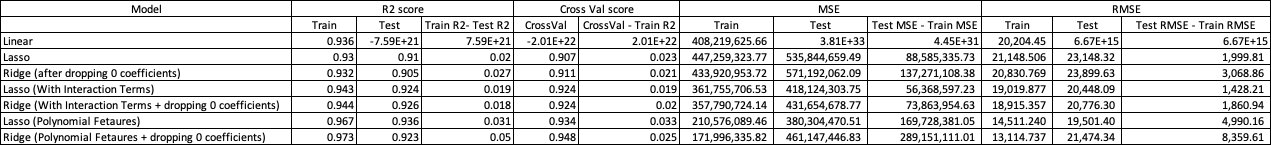

We see that even though the R2 test score is highest for Polynomial features, the difference between Train and test scores is also the highest increasing the chances of overfitting. This is also true for MSE and RMSE scores. We find that the **Ridge model (ridge_cv4)** with Interaction terms, and after dropping the 0 coefficients from Lasso, is the best model for our data. 

### Let's predict the values for the external test data

In [1906]:
df_ames_dummy_test


,id,pid,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,...,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,2658,902301120,69.0,9142,3,2,2,6,8,1910,...,0,0,0,0,0,0,0,0,0,1
1,2718,905108090,68.0,9662,2,2,2,5,4,1977,...,0,0,0,0,0,0,0,0,0,1
2,2414,528218130,58.0,17104,2,2,2,7,5,2006,...,0,0,0,0,0,0,1,0,0,0
3,1989,902207150,60.0,8520,3,2,2,5,6,1923,...,0,0,0,0,0,0,0,0,0,1
4,625,535105100,68.0,9500,2,2,2,6,5,1963,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,80.0,8000,3,2,2,6,6,1974,...,0,0,0,0,0,0,0,0,0,1
874,1234,535126140,90.0,14670,3,2,2,6,7,1966,...,0,0,0,0,0,0,0,0,0,1
875,1373,904100040,55.0,8250,3,2,2,5,5,1968,...,0,0,0,0,0,0,0,0,0,1
876,1672,527425140,60.0,9000,3,2,2,4,6,1971,...,0,0,0,0,0,0,0,0,0,1


In [1907]:
#We scale our test dataset data with the same StandardScaler object

df_ames_dummy_test_no_ids = df_ames_dummy_test.drop(columns=["id", "pid"])
df_ames_dummy_test_no_ids.shape

X_external_test_sc = ss.transform(df_ames_dummy_test_no_ids)
X_external_test_sc = pd.DataFrame(X_external_test_sc, index=df_ames_dummy_test_no_ids.index, columns=df_ames_dummy_test_no_ids.columns)


In [1908]:
X_external_test_sc

,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,0.014722,-0.144846,0.710655,0.025624,0.208033,-0.068383,2.218821,-2.044048,-1.612879,-0.578783,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345
1,-0.034698,-0.045177,-1.047524,0.025624,0.208033,-0.763149,-1.402580,0.169434,-0.338238,-0.578783,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345
2,-0.528898,1.381227,-1.047524,0.025624,0.208033,0.626384,-0.497230,1.127508,1.030821,-0.578783,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,3.330952,-0.051299,0.0,-2.529438
3,-0.430058,-0.264064,0.710655,0.025624,0.208033,-0.763149,0.408121,-1.614566,1.030821,-0.578783,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345
4,-0.034698,-0.076228,-1.047524,0.025624,0.208033,-0.068383,-0.497230,-0.293084,-0.999163,0.849948,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,0.558342,-0.363732,0.710655,0.025624,0.208033,-0.068383,0.408121,0.070323,-0.479865,-0.578783,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345
874,1.052542,0.914704,0.710655,0.025624,0.208033,-0.068383,1.313471,-0.193973,0.700359,1.792794,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345
875,-0.677158,-0.315815,0.710655,0.025624,0.208033,-0.763149,-0.497230,-0.127899,-0.763118,-0.578783,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345
876,-0.430058,-0.172063,0.710655,0.025624,0.208033,-1.457916,0.408121,-0.028788,-0.621491,-0.578783,...,-0.025624,-0.062869,-0.044412,-0.089087,-0.057373,-0.051299,-0.300215,-0.051299,0.0,0.395345


In [1909]:
# We drop the variables with zero coefficients found from the two Lasso Model before

X_external_test_regularised = X_external_test_sc.drop(columns=drop_columns)
X_external_test_regularised

,lot_frontage,lot_area,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,...,garage_type_BuiltIn,garage_type_NA,misc_feature_Othr,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLw,sale_type_New,sale_type_Oth
0,0.014722,-0.144846,0.208033,-0.068383,2.218821,-2.044048,-1.612879,-0.578783,-0.688340,-2.917384,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
1,-0.034698,-0.045177,0.208033,-0.763149,-1.402580,0.169434,-0.338238,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
2,-0.528898,1.381227,0.208033,0.626384,-0.497230,1.127508,1.030821,-0.578783,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,3.330952,-0.051299
3,-0.430058,-0.264064,0.208033,-0.763149,0.408121,-1.614566,1.030821,-0.578783,1.011872,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
4,-0.034698,-0.076228,0.208033,-0.068383,-0.497230,-0.293084,-0.999163,0.849948,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,0.558342,-0.363732,0.208033,-0.068383,0.408121,0.070323,-0.479865,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
874,1.052542,0.914704,0.208033,-0.068383,1.313471,-0.193973,0.700359,1.792794,1.011872,2.458787,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
875,-0.677158,-0.315815,0.208033,-0.763149,-0.497230,-0.127899,-0.763118,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299
876,-0.430058,-0.172063,0.208033,-1.457916,0.408121,-0.028788,-0.621491,-0.578783,-0.688340,-0.229299,...,-0.259281,-0.243041,-0.044412,-0.025624,-0.062869,-0.044412,-0.089087,-0.051299,-0.300215,-0.051299


In [1910]:
X_external_test_regularised.shape

(878, 123)

In [1911]:
# We add the new interaction feature to the test data set

X_external_test_regularised['gr_liv_area*overall_qual'] = X_external_test_regularised['gr_liv_area'] * X_external_test_sc['overall_qual']


In [1912]:
X_external_test_regularised['overall_cond*year_remod/add'] = X_external_test_regularised['overall_cond'] * X_external_test_regularised['year_remod/add']


In [1913]:
X_external_test_regularised['garage_cars*garage_area'] = X_external_test_regularised['garage_cars'] * X_external_test_regularised['garage_area']


In [1914]:
X_external_test_regularised['lot_frontage*lot_area'] = X_external_test_regularised['lot_frontage'] * X_external_test_regularised['lot_area']


In [1915]:
X_external_test_regularised['bsmt_qual*bsmt_exposure'] = X_external_test_regularised['bsmt_qual'] * X_external_test_regularised['bsmt_exposure']


In [1916]:
X_external_test_regularised['overall_qual*functional'] = X_external_test_regularised['overall_qual'] * X_external_test_regularised['functional']


In [1917]:
X_external_test_regularised = X_external_test_regularised.drop(columns=drop_columns_2)
X_external_test_regularised

,lot_frontage,lot_area,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,...,sale_type_Con,sale_type_ConLw,sale_type_New,sale_type_Oth,gr_liv_area*overall_qual,overall_cond*year_remod/add,garage_cars*garage_area,lot_frontage*lot_area,bsmt_qual*bsmt_exposure,overall_qual*functional
0,0.014722,-0.144846,0.208033,-0.068383,2.218821,-2.044048,-1.612879,-0.578783,-0.688340,-2.917384,...,-0.044412,-0.051299,-0.300215,-0.051299,-0.060190,-3.578691,0.153844,-0.002132,0.961100,-0.016307
1,-0.034698,-0.045177,0.208033,-0.763149,-1.402580,0.169434,-0.338238,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,-0.733160,0.474406,0.143048,0.001568,-0.332248,-0.181984
2,-0.528898,1.381227,0.208033,0.626384,-0.497230,1.127508,1.030821,-0.578783,1.011872,-0.229299,...,-0.044412,-0.051299,3.330952,-0.051299,-0.007252,-0.512555,-0.063639,-0.730528,0.732622,0.149371
3,-0.430058,-0.264064,0.208033,-0.763149,0.408121,-1.614566,1.030821,-0.578783,1.011872,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.840625,0.420699,0.008836,0.113563,0.314426,-0.181984
4,-0.034698,-0.076228,0.208033,-0.068383,-0.497230,-0.293084,-0.999163,0.849948,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.015190,0.496814,0.054468,0.002645,-0.332248,-0.016307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,0.558342,-0.363732,0.208033,-0.068383,0.408121,0.070323,-0.479865,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,-0.052991,-0.195843,0.019573,-0.203087,0.314426,-0.016307
874,1.052542,0.914704,0.208033,-0.068383,1.313471,-0.193973,0.700359,1.792794,1.011872,2.458787,...,-0.044412,-0.051299,-0.300215,-0.051299,-0.068660,0.919901,0.008836,0.962764,0.314426,-0.016307
875,-0.677158,-0.315815,0.208033,-0.763149,-0.497230,-0.127899,-0.763118,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,0.457813,0.379445,0.697094,0.213856,0.314426,-0.181984
876,-0.430058,-0.172063,0.208033,-1.457916,0.408121,-0.028788,-0.621491,-0.578783,-0.688340,-0.229299,...,-0.044412,-0.051299,-0.300215,-0.051299,1.918920,-0.253643,0.073258,0.073997,0.314426,-0.347662


In [1918]:
# We use the lasso model to predict y values
y_external_test = pd.DataFrame()
y_external_test['Id'] = df_ames_dummy_test['id']
y_external_test['SalePrice'] = ridge_cv4.predict(X_external_test_regularised)


In [1919]:
y_external_test

,Id,SalePrice
0,2658,144658.137835
1,2718,152437.436734
2,2414,223805.850651
3,1989,100344.861318
4,625,174458.672418
...,...,...
873,1662,187084.600920
874,1234,213346.303807
875,1373,123523.784982
876,1672,118714.046537


In [1920]:
#The predicted values are the log of actual sale price, so we do inverse of the log values. 
#y_external_test['SalePrice'] = np.exp(y_external_test['SalePrice'])

In [1921]:
y_external_test.to_csv('datasets/submission.csv', index=False)

### Kaggle Submission

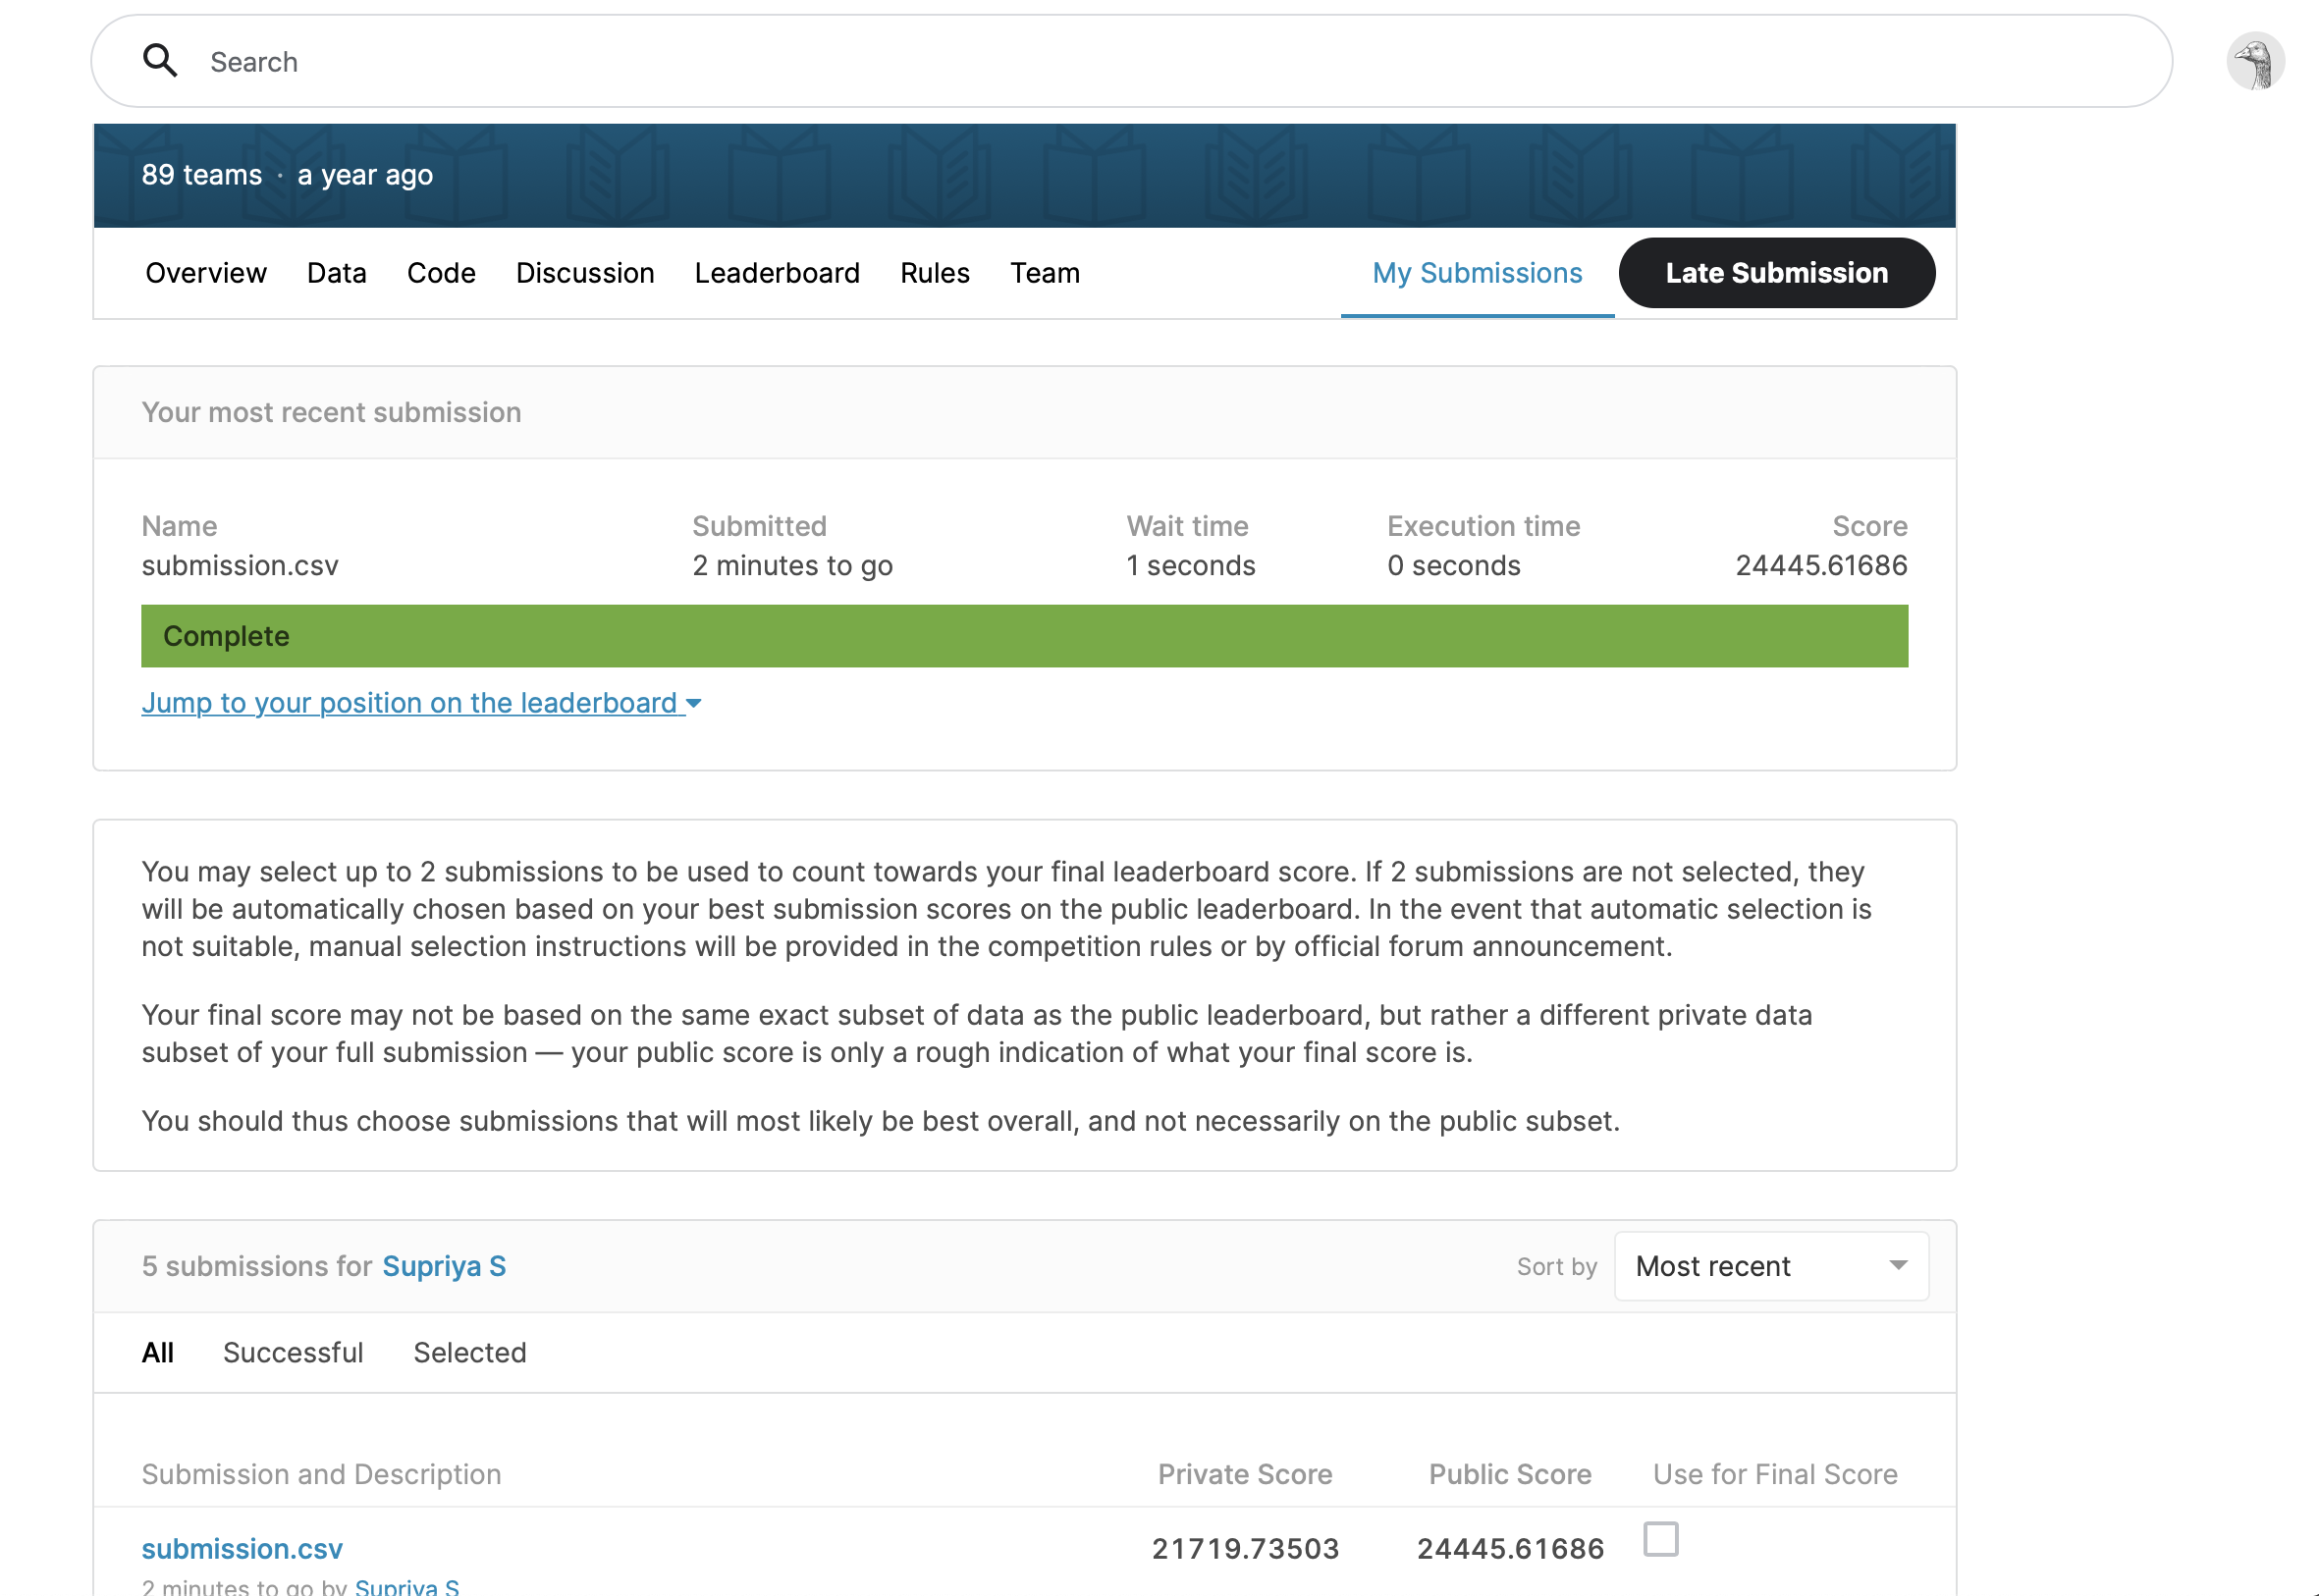

## Conclusion

After analysing the Ames dataset using Linear Regression, Lasso Regression and Ridge Regression we come to the following conclusions:

### Bigger houses fetch better Sale Price
We see that the following factors related to the house size have the some of the highest coefficients:
- High Ground living area
- High Basement Area
- High Lot Area

### Better quality houses fetch better Sale Price
We see that the following factors related to the quality of the houses also have the some of the highest coefficients:

- Overall quality
- External quality

### Good Basement quality & exposure enhances the Sale Price
We found that the interaction variable for bsmt_quality\*bsmt_exposure has a high coefficient.

### Newer houses positively influence the Sale Price
We find that Year Built has a high influence on the Sale Price, newer houses sell at higher prices. 

### Not having a garage lowers the Sale Price
Garage_Type_NA variable has a high negative coefficient showing that having no garage lowers the sale price of the house. 

## Recommendations to Home Owners

- Home Owners can consider undertaking renovation and improving the overall quality of the house by using material of better quality and finish. 
- They should focus on specifically improving the external quality using better quality material on the exterior.
- Home owners may set their expectations about their property value according to:
    - Size of their Ground Living Area, Basement, Lot Area
    - Year in which the house was built
    - Basement quality & exposure
    - Neighbourhood (Stone Bridge, Northridge Heights, Green Hills have better Sale Price)
